# The Eight Schools Problem with PyMC4

In [7]:
import warnings
warnings.filterwarnings("ignore")
import os
import tensorflow as tf
# from tensorflow_probability import edward2 as ed
# from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from pymc4.inference.sampling.sample import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 
import pymc3 as pm

In [8]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.

## Centered Eight Schools

In [10]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [11]:
with Centered_eight:
    short_trace = pm.sample(1200, chains=1, random_seed=54)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta, tau, mu]


Sampling 1 chain for 1_000 tune and 1_200 draw iterations (1_000 + 1_200 draws total) took 6 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
pm3.summary(short_trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,4.655,3.105,0.162,-1.696,10.520
theta__0,6.979,5.885,0.282,-4.199,19.092
theta__1,5.248,4.787,0.188,-3.609,16.081
theta__2,4.070,5.245,0.234,-6.745,14.749
theta__3,5.047,4.795,0.193,-4.795,14.626
theta__4,3.979,4.762,0.198,-7.953,12.240
theta__5,4.363,4.819,0.196,-5.899,14.258
theta__6,6.757,5.000,0.234,-2.017,17.388
theta__7,5.094,5.286,0.234,-5.241,15.997
tau,3.987,3.110,0.224,0.577,10.037


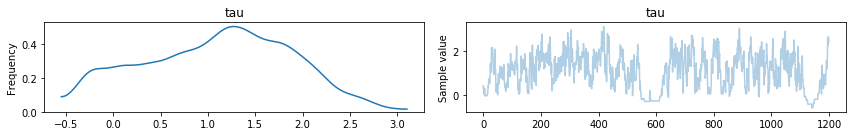

In [6]:
# plot the trace of log(tau)
pm3.traceplot(short_trace, varnames=['tau'], transform=np.log);

In [7]:
with Centered_eight:
    longer_trace = pm3.sample(4000, chains=2, tune=1000, random_seed=54)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau_log__, mu]
100%|██████████| 5000/5000 [00:11<00:00, 430.94it/s]
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6796303528986296, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
pm3.summary(longer_trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.772,3.927,0.219,-1.150,14.901,83.503,1.004
theta__0,7.016,5.970,0.194,-3.777,19.157,381.389,1.003
theta__1,5.486,5.289,0.204,-4.370,15.699,198.925,1.002
theta__2,4.193,5.977,0.226,-7.922,14.893,204.378,1.002
theta__3,5.205,5.478,0.213,-5.477,15.322,212.728,1.002
theta__4,3.823,5.303,0.238,-5.524,15.036,134.126,1.000
theta__5,4.341,5.650,0.237,-5.801,15.531,157.387,1.003
theta__6,7.103,5.472,0.181,-3.481,17.450,374.376,1.002
theta__7,5.384,5.960,0.217,-7.348,15.561,213.063,1.004
tau,4.382,3.269,0.134,0.878,10.661,323.020,1.001


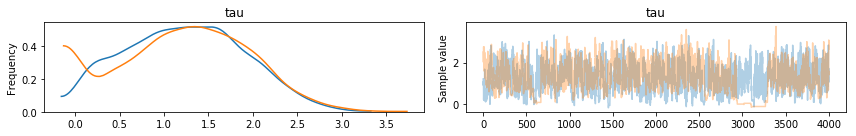

In [9]:
# plot the trace of log(tau)
pm3.traceplot(longer_trace, varnames=['tau'], transform=np.log);

In [10]:
np.float32(y).dtype

dtype('float32')

In [11]:
model = pm.Model(num_schools=J, y=y, sigma=sigma )
@model.define
def process(cfg):
    mu = ed.Normal(loc=0., scale=5., name="mu")  # `mu` above
    # Due to the lack of HalfCauchy distribution.
    log_tau = ed.Normal(
        loc=5., scale=1., name="log_tau")  # `log(tau)` above
    theta_prime = ed.Normal(
        loc=tf.zeros(cfg.num_schools),
        scale=tf.ones(cfg.num_schools),
        name="theta_prime")  # `theta_prime` above
    theta = mu + tf.exp(
        log_tau) * theta_prime  # `theta` above
    y = ed.Normal(
        loc=theta,
        scale=np.float32(cfg.sigma),
        name="y")  # `y` above
    
    return y

In [12]:
model.observe(y = model.cfg.y)

In [13]:
model.observed

{'y': array([28.,  8., -3.,  7., -1.,  1., 18., 12.])}

In [14]:
model.unobserved

OrderedDict([('mu',
              VariableDescription(Dist=<class 'tensorflow.python.ops.distributions.normal.Normal'>, shape=TensorShape([]), rv=<ed.RandomVariable 'mu' shape=() dtype=float32>)),
             ('log_tau',
              VariableDescription(Dist=<class 'tensorflow.python.ops.distributions.normal.Normal'>, shape=TensorShape([]), rv=<ed.RandomVariable 'log_tau' shape=() dtype=float32>)),
             ('theta_prime',
              VariableDescription(Dist=<class 'tensorflow.python.ops.distributions.normal.Normal'>, shape=TensorShape([Dimension(8)]), rv=<ed.RandomVariable 'theta_prime' shape=(8,) dtype=float32>))])

In [15]:
with tf.Session():
    print(model._f(model._cfg).eval())

[-72.16133  -72.965164  95.40658   15.025141  12.754717 107.28393
 -24.945261 -30.989164]


## LogP Mismatch

In [41]:
Centered_eight.logp(mu=1, tau_log__=1, theta=[1,1,1,1,1,1,1,1])

array(-50.24198446)

In [42]:
pymc4_log_prob = model.target_log_prob_fn()

In [43]:
model.unobserved

OrderedDict([('mu',
              VariableDescription(Dist=<class 'tensorflow.python.ops.distributions.normal.Normal'>, shape=TensorShape([]), rv=<ed.RandomVariable 'mu' shape=() dtype=float32>)),
             ('log_tau',
              VariableDescription(Dist=<class 'tensorflow.python.ops.distributions.normal.Normal'>, shape=TensorShape([]), rv=<ed.RandomVariable 'log_tau' shape=() dtype=float32>)),
             ('theta_prime',
              VariableDescription(Dist=<class 'tensorflow.python.ops.distributions.normal.Normal'>, shape=TensorShape([Dimension(8)]), rv=<ed.RandomVariable 'theta_prime' shape=(8,) dtype=float32>))])

In [53]:
with tf.Session():
    print(pymc4_log_prob(1, 1., (1., 1., 1., 1., 1., 1., 1., 1.)).eval())

-52.967716


In [16]:
trace = sample(model, num_burnin_steps=1000, num_results=5000)

/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use 

/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use 

Acceptance rate: 0.6192


In [17]:
trace

{'mu': array([-1.4385958, -1.4385958, -1.4385958, ...,  9.872691 ,  8.878326 ,
         8.165668 ], dtype=float32),
 'log_tau': array([2.6707418, 2.6707418, 2.6707418, ..., 3.1494684, 1.3626628,
        2.6146834], dtype=float32),
 'theta_prime': array([[ 0.9217021 ,  0.7332041 , -0.69482315, ...,  0.31827638,
          0.87768406,  0.93878686],
        [ 0.9217021 ,  0.7332041 , -0.69482315, ...,  0.31827638,
          0.87768406,  0.93878686],
        [ 0.9217021 ,  0.7332041 , -0.69482315, ...,  0.31827638,
          0.87768406,  0.93878686],
        ...,
        [ 0.12429702, -0.19490498, -1.5399917 , ..., -0.30469486,
          0.22185168, -0.52403253],
        [ 0.9992132 ,  0.9186932 ,  0.71775293, ..., -0.19752336,
         -0.77504003, -0.24895237],
        [-0.62771237,  1.1626923 , -1.2299166 , ..., -1.2041072 ,
          0.42344823, -0.89037424]], dtype=float32)}

In [18]:
theta = (
    trace['mu'][:, np.newaxis] +
    np.exp(trace['log_tau'])[:, np.newaxis] * trace['theta_prime'])

In [19]:
theta.shape

(5000, 8)

(array([  9.,  55.,  91., 160., 261., 292., 285., 353., 355., 334., 372.,
        332., 276., 229., 212., 208., 220., 158., 117., 108., 102., 100.,
         45.,  64.,  27.,  35.,  18.,  50.,  21.,   9.,  42.,  25.,   5.,
          4.,   1.,   4.,   0.,   1.,  15.,   5.]),
 array([ 1.0316025,  2.0316025,  3.0316025,  4.0316025,  5.0316025,
         6.0316025,  7.0316025,  8.0316025,  9.0316025, 10.0316025,
        11.0316025, 12.0316025, 13.0316025, 14.0316025, 15.0316025,
        16.0316025, 17.0316025, 18.0316025, 19.0316025, 20.0316025,
        21.0316025, 22.0316025, 23.0316025, 24.0316025, 25.0316025,
        26.0316025, 27.0316025, 28.0316025, 29.0316025, 30.0316025,
        31.0316025, 32.0316025, 33.0316025, 34.0316025, 35.0316025,
        36.0316025, 37.0316025, 38.0316025, 39.0316025, 40.0316025,
        41.0316025]),
 <a list of 40 Patch objects>)

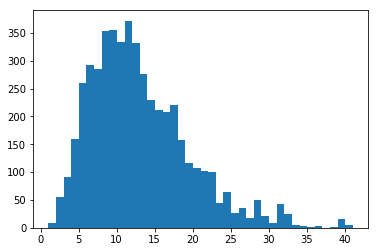

In [20]:
# trace plot tau
import seaborn as sns
plt.hist(np.exp(trace['log_tau']), bins=np.arange(np.exp(trace['log_tau']).min(), np.exp(trace['log_tau']).max()+1))
# sns.distplot(np.exp(trace['log_tau']))

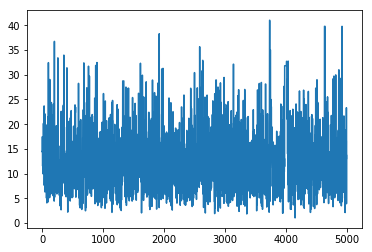

In [21]:
plt.plot(np.exp(trace['log_tau']))

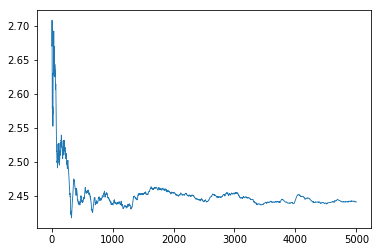

In [24]:
plt.plot(mlogtau, lw=0.9)

In [25]:
theta[:,0].shape

(5000,)

In [26]:
print(theta.shape)

for school in range(theta.shape[1]):
    print(str(school) + " Mean:", np.mean(theta[:, school]), "sd:", np.std(theta[:, school]))

(5000, 8)
0 Mean: 13.1466675 sd: 10.361167
1 Mean: 6.248073 sd: 7.912224
2 Mean: 1.172592 sd: 10.112816
3 Mean: 5.117202 sd: 8.129532
4 Mean: 0.76633567 sd: 7.127367
5 Mean: 2.0183334 sd: 8.09595
6 Mean: 11.76272 sd: 8.364141
7 Mean: 6.1588736 sd: 10.1365595


In [27]:
for i in trace.keys():
    if i != "log_tau":
        print(i, "Mean:", np.mean(trace[i]))
    else:
        print("tau Mean:", np.mean(np.exp(trace[i])))

mu Mean: 3.3309453
tau Mean: 13.029848
theta_prime Mean: 0.17966528


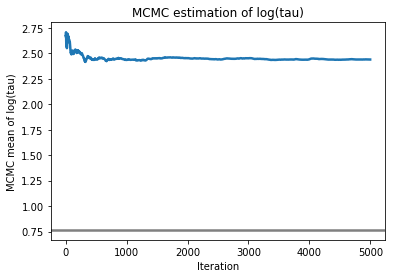

In [23]:
mlogtau = [np.mean(trace["log_tau"][:i]) for i in np.arange(1, len(trace["log_tau"]))]
# plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
# plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');


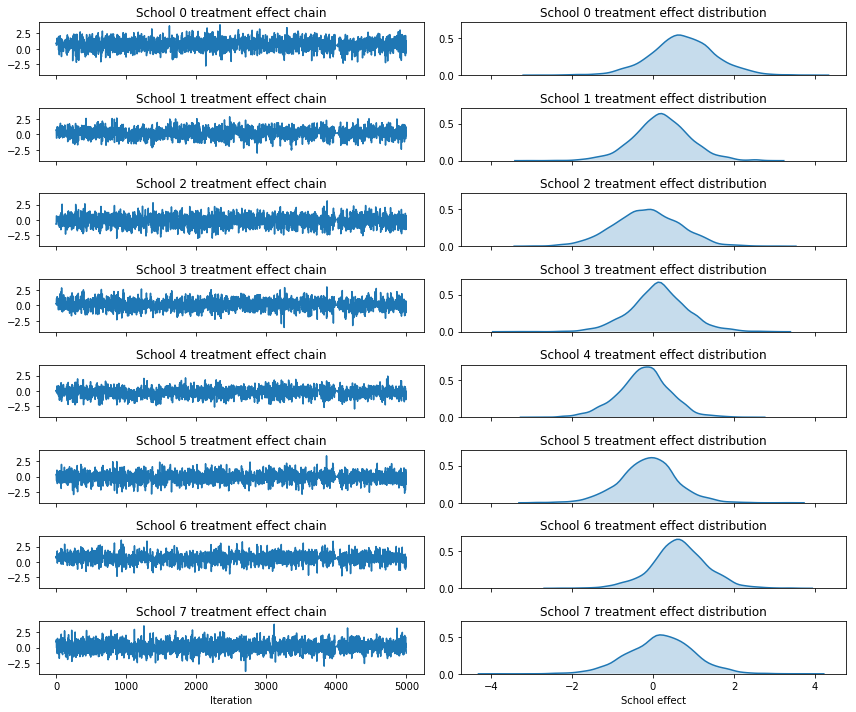

In [32]:
import warnings
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(J):
    axes[i][0].plot(trace['theta_prime'][:,i])
    axes[i][0].title.set_text("School {} treatment effect chain".format(i))
    sns.kdeplot(trace['theta_prime'][:,i], ax=axes[i][1], shade=True)
    axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[J - 1][0].set_xlabel("Iteration")
axes[J - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [34]:
school_effects_low = np.array([
    np.percentile(trace["theta_prime"][:, i], 2.5) for i in range(J)
])
school_effects_med = np.array([
    np.percentile(trace["theta_prime"][:, i], 50) for i in range(J)
])
school_effects_hi = np.array([
    np.percentile(trace["theta_prime"][:, i], 97.5)
    for i in range(J)
])

In [35]:
print("Inferred posterior mean: {0:.2f}".format(
    np.mean(trace["theta_prime"][:,])))
print("Inferred posterior mean se: {0:.2f}".format(
    np.std(trace["theta_prime"][:,])))

Inferred posterior mean: 0.18
Inferred posterior mean se: 0.81
